### Reading:
 - https://medium.com/ai%C2%B3-theory-practice-business/understanding-hintons-capsule-networks-part-i-intuition-b4b559d1159b
 - https://github.com/higgsfield/Capsule-Network-Tutorial/blob/master/Capsule%20Network.ipynb
 - 

In [1]:
import torch

In [2]:
torch.__version__

'1.0.1.post2'

In [3]:
%matplotlib inline

## I. Load and plot data MNIST dataset

In [4]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
    
    
class Dataset:
    def __init__(self, dataset, _batch_size=30):
        super(Dataset, self).__init__()
        if dataset == 'mnist':
            dataset_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])

            train_dataset = datasets.MNIST('/fast/data/', train=True, download=True,
                                           transform=dataset_transform)
            test_dataset = datasets.MNIST('/fast/data/', train=False, download=True,
                                          transform=dataset_transform)
            self.img_shape = (28, 28)
            self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=_batch_size, shuffle=True)
            self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=_batch_size, shuffle=False)

        elif dataset == 'cifar10':
            data_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
            train_dataset = datasets.CIFAR10(
                '/data/cifar', train=True, download=True, transform=data_transform)
            test_dataset = datasets.CIFAR10(
                '/data/cifar', train=False, download=True, transform=data_transform)

            self.train_loader = torch.utils.data.DataLoader(
                train_dataset, batch_size=_batch_size, shuffle=True)

            self.test_loader = torch.utils.data.DataLoader(
                test_dataset, batch_size=_batch_size, shuffle=False)
        elif dataset == 'office-caltech':
            pass
        elif dataset == 'office31':
            pass
        
    def plot_images(self, images, cls_true, cls_pred=None):
        assert len(images) == len(cls_true) == 9

        # Create figure with 3x3 sub-plots.
        fig, axes = plt.subplots(3, 3)
        fig.subplots_adjust(hspace=0.3, wspace=0.3)

        for i, ax in enumerate(axes.flat):
            # Plot image.
            ax.imshow(images[i].reshape(self.img_shape), cmap='binary')

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true[i])
            else:
                xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

            ax.set_xlabel(xlabel)

            # Remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])

        # Ensure the plot is shown correctly with multiple plots
        # in a single Notebook cell.
        plt.show()

In [5]:
data = Dataset('mnist')

In [6]:
iter_train = iter(data.train_loader)

In [7]:
x, y = next(iter_train)
x.shape,y.shape

(torch.Size([30, 1, 28, 28]), torch.Size([30]))

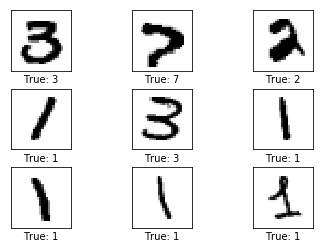

In [8]:
data.plot_images(images=x[0:9], cls_true=y[0:9])

## II. Create model:
 - Encoder.
 - Decoder.

### Encoder:
 - Layer 1: conv.
 - Layer 2: primary caps.
 - Layer 3: Digital caps.

![Image of Yaktocat](./capsule_n.png)

In [9]:
from torch import nn

In [10]:
# Layer 1: conv
class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, out_channels=256, kernel_size=9):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.conv(x)
        out = self.relu(out)
        return out
    
layer1 = ConvLayer()
l1_out = layer1(x)
l1_out.shape

torch.Size([30, 256, 20, 20])

In [11]:
# Layer 2: PrimaryCaps layer:
class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=32, in_channels=256, out_channels=8, kernel_size=9):
        super(PrimaryCaps, self).__init__()
        self.convs = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size, stride=2) for _ in range(num_capsules)])
        self.relu = nn.ReLU()
    def forward(self, x):
        out = [self.relu(conv(x)) for conv in self.convs]
        return out
layer2 = PrimaryCaps()

In [12]:
l2_out = layer2(l1_out)

In [13]:
l2_out[0].shape

torch.Size([30, 8, 6, 6])

In [17]:
# Layer 3: Digital caps layer:
class DigitalCaps(nn.Module):
    def __init__(self):
        super(DigitalCaps, self).__init__()
    def forward(self, x):
        pass